In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import talib
from mpl_finance import candlestick2_ohlc, candlestick_ohlc
import matplotlib.dates as mdates

%matplotlib inline

In [3]:
codeList = ['A005930', 'A000660', 'A068270', 'A207940', 'A005380', 'A005490',\
            'A051910', 'A035420', 'A028260', 'A012330', 'A017670', 'A105560',\
            'A055550', 'A015760', 'A051900', 'A018260', 'A034730', 'A032830',\
            'A096770', 'A006400', 'A145020', 'A051370', 'A037460', 'A088800']
stName = ['삼성전자', 'SK하이닉스', '셀트리온', '삼성바이오로직스', '현대차', 'POSCO',\
          'LG화학', 'NAVER', '삼성물산', '현대모비스', 'SK텔레콤', 'KB금융', \
          '신한지주', '한국전력', 'LG생활건강', '삼성에스디에스', 'SK', '삼성생명',\
          'SK이노베이션', '삼성SDI', '휴젤', '인터플렉스', '삼지전자', '에이스테크']
Name2Code = {nm:code for nm, code in zip(stName, codeList)}
print(Name2Code)

{'삼성전자': 'A005930', 'SK하이닉스': 'A000660', '셀트리온': 'A068270', '삼성바이오로직스': 'A207940', '현대차': 'A005380', 'POSCO': 'A005490', 'LG화학': 'A051910', 'NAVER': 'A035420', '삼성물산': 'A028260', '현대모비스': 'A012330', 'SK텔레콤': 'A017670', 'KB금융': 'A105560', '신한지주': 'A055550', '한국전력': 'A015760', 'LG생활건강': 'A051900', '삼성에스디에스': 'A018260', 'SK': 'A034730', '삼성생명': 'A032830', 'SK이노베이션': 'A096770', '삼성SDI': 'A006400', '휴젤': 'A145020', '인터플렉스': 'A051370', '삼지전자': 'A037460', '에이스테크': 'A088800'}


In [51]:
nm = "인터플렉스"
close = pd.read_hdf('../data/daily_price_sample.h5', Name2Code[nm])
close.head(5)

date   open   high    low  close     vol   marketValue
date                                                                  
2016-08-22  20160822  20300  20900  19350  20500  399805  335790000000
2016-08-23  20160823  20500  20650  19400  19800  237642  324324000000
2016-08-24  20160824  19900  20100  19200  19500  214600  319410000000
2016-08-25  20160825  19600  19950  18350  18450  303416  302211000000
2016-08-26  20160826  18500  19400  18250  19100  315927  312858000000

In [53]:
# trend condition
def set_cond(close):
    b_volume_ratio = close['vol'] >= close['vol'].rolling(20).mean() * 2.5
    b_positive = close['close'] > close['open']
    b_newhigh = close['close'] > close['close'].rolling(60).max() * 0.95
    b_newhigh2 = close['close'].shift(1) != close['close'].rolling(60).max()
    b_cond = b_volume_ratio & b_positive & b_newhigh & b_newhigh2
    return b_cond

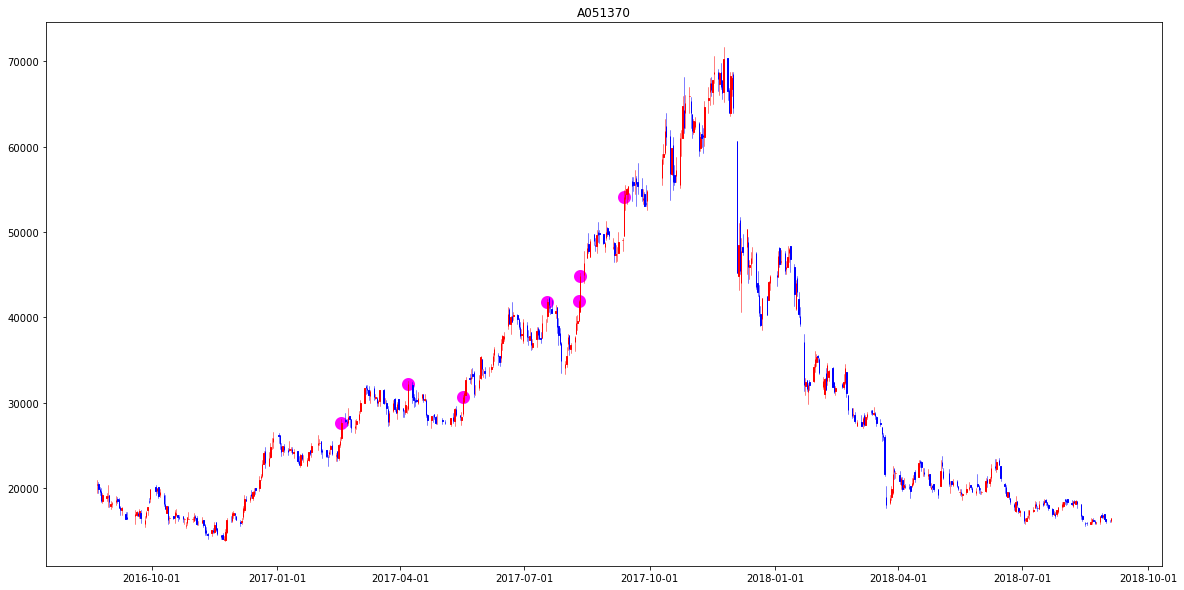

In [54]:
# Plot when signal is triggered!
b_cond = set_cond(close)

fig, ax = plt.subplots(1,1, figsize=(20,10))
ax.set_title(Name2Code[nm])

close['date'] = close.index.map(mdates.date2num)  # 그래프의 x축에 일자를 표시하기 위해 data 형태 변경
candlestick_ohlc(ax, close.loc[:, ['date', 'open', 'high', 'low', 'close']].values,\
                 colorup='red', colordown='blue', width=0.3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

ax.scatter(close.index[b_cond], close.loc[b_cond, "close"].values, c='fuchsia', linewidths=7)
# ax1.plot(close.index, close['vol'])

plt.show()

In [7]:
def cal_portion(f, profit, damping=0.2):
    if profit < 1:
        if f > damping:
            f_new = f - damping
        else:
            f_new = 0
    else:
        if f <= 1 - damping * 2:
            f_new = f + damping * 2
        else:
            f_new = 1
    return f_new

In [8]:
def cal_momentum(close, lag=6):
    '''
    close : pd.Series
    '''
    moments = pd.Series(np.ones_like(close), index=close.index)
    for i in range(lag):
        moments *= (close.pct_change(i) + 1)
    return moments ** (1 / (lag - 1))

In [55]:
def simulation(b_cond, losscut_ratio=0.02, is_show=False, is_losscut=False, is_manage=False):
    profit = close['close']
    
    cummax = profit.iloc[0]
    bid_price = profit.iloc[0]
    close_done = True
    bid_done = False
    
    fee = pd.Series(np.ones_like(profit), index=profit.index)
    portions = pd.Series(np.ones_like(profit), index=profit.index)
    cummaxs = pd.Series(np.ones_like(profit), index=profit.index)
    
    n_trade = 0
    portion = 1.0
    is_capture = pd.Series(False, index=profit.index)
    
    if is_show:
        plt.figure()
        profit.plot()
        plt.ion()

    for idx, bid in enumerate(b_cond.values):
        if bid and close_done:
            bid_price = profit.iloc[idx]
            cummax = bid_price
            fee[idx] *= (1 - 0.00315)
            bid_done = True
            close_done = False
            if is_show:
                plt.scatter(b_cond.index[idx], bid_price, color='r')

        cummax = np.maximum(cummax, profit.iloc[idx])
        cummaxs[idx] = cummax

        is_maxdrop = cummax * (1 - 0.15) > profit.iloc[idx]

        if is_losscut:
            is_loss = bid_price * (1 - losscut_ratio) > profit.iloc[idx]
            is_maxdrop = is_maxdrop or is_loss

        if bid_done and is_maxdrop:
            ask_price = profit.iloc[idx]
            fee[idx] *= (1 - 0.00315)

            portion = cal_portion(portion, ask_price / bid_price * (1 - 0.00315))
            close_done = True
            bid_done = False
            n_trade += 1
            
            if is_show:
                plt.scatter(b_cond.index[idx], ask_price, color='c')
            
        if bid_done and ~close_done and idx == b_cond.shape[0] - 1:
            ask_price = profit.iloc[idx]
            fee[idx] *= (1 - 0.00315)

            portion = cal_portion(portion, ask_price / bid_price * (1 - 0.00315))
            close_done = True
            bid_done = False
            n_trade += 1
            
            if is_show:
                plt.scatter(b_cond.index[idx], ask_price, color='c')

        if is_manage:
            portions[idx] = portion

        if bid_done and ~close_done:
            is_capture[idx] = True
            
    if is_show:
        cummaxs.plot()
    print("Total number of trade : %d" % (n_trade))
    return profit, portions, fee, is_capture

Total number of trade : 2
Total Profit : 1.3613 / MDD : -0.3570


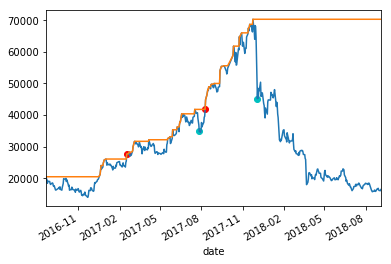

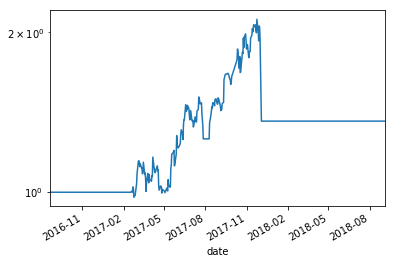

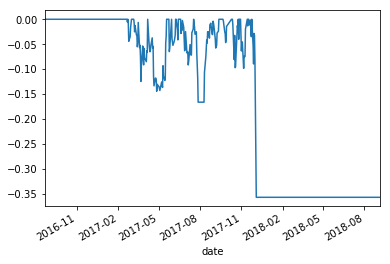

In [56]:
profit, portions, fee, is_capture = simulation(b_cond, is_show=True, is_losscut=False, is_manage=True)

prf = (profit.pct_change(1) + 1)
is_cap_ = is_capture.shift(1).fillna(False)

plt.figure("profit")
prf[~is_cap_] = 1.0
prf_cap = prf.cumprod()
prf_cap.plot(logy=True)

plt.figure("mdd")
mdd = (prf_cap - prf_cap.cummax()) / prf_cap.cummax()
mdd.plot()
print("Total Profit : {0:0.4f} / MDD : {1:0.4f}".format(prf_cap[-1], mdd.min()))

Total number of trade : 1
[삼성전자]Total Profit : 0.9398
Total number of trade : 1
[SK하이닉스]Total Profit : 0.8447
Total number of trade : 1
[셀트리온]Total Profit : 2.5179
Total number of trade : 2
[삼성바이오로직스]Total Profit : 2.0548
Total number of trade : 1
[현대차]Total Profit : 0.8382
Total number of trade : 0


c:\anaconda3(32)\lib\site-packages\matplotlib\axes\_base.py:3179: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))


[POSCO]Total Profit : 1.0000
Total number of trade : 2
[LG화학]Total Profit : 1.3615
Total number of trade : 0
[NAVER]Total Profit : 1.0000
Total number of trade : 3
[삼성물산]Total Profit : 0.7057
Total number of trade : 2
[현대모비스]Total Profit : 0.6921
Total number of trade : 2
[SK텔레콤]Total Profit : 1.0826
Total number of trade : 0
[KB금융]Total Profit : 1.0000
Total number of trade : 1
[신한지주]Total Profit : 0.8977
Total number of trade : 2
[한국전력]Total Profit : 0.7359
Total number of trade : 1
[LG생활건강]Total Profit : 1.1040
Total number of trade : 3
[삼성에스디에스]Total Profit : 1.0393
Total number of trade : 1
[SK]Total Profit : 1.0920
Total number of trade : 1
[삼성생명]Total Profit : 1.0219
Total number of trade : 1
[SK이노베이션]Total Profit : 1.0853
Total number of trade : 1
[삼성SDI]Total Profit : 1.3000
Total number of trade : 1


c:\anaconda3(32)\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


[휴젤]Total Profit : 1.2745
Total number of trade : 2
[인터플렉스]Total Profit : 1.3613
Total number of trade : 3
[삼지전자]Total Profit : 1.0425
Total number of trade : 3
[에이스테크]Total Profit : 1.4954
Total Profit : 1.2388 / MDD : -0.0710


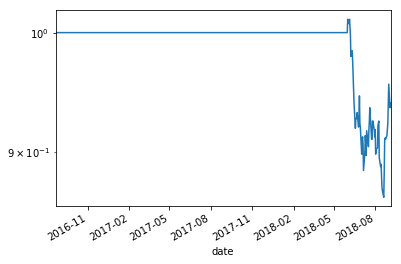

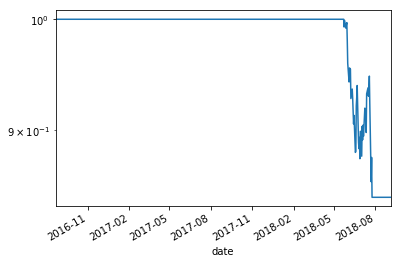

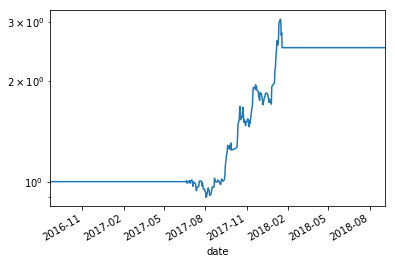

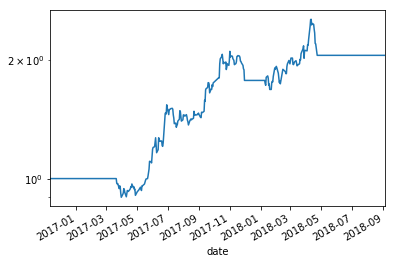

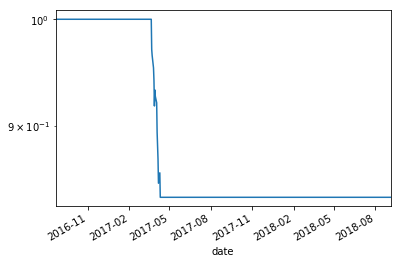

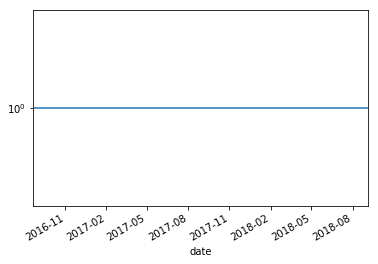

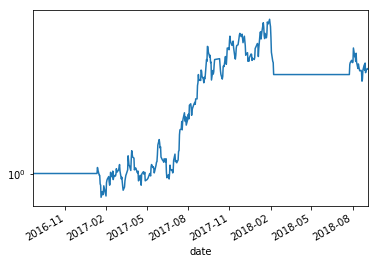

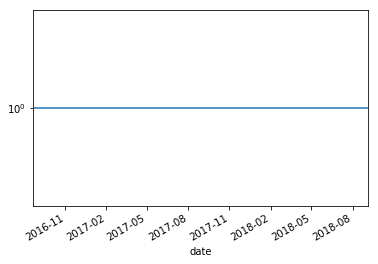

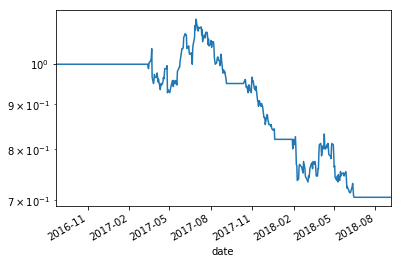

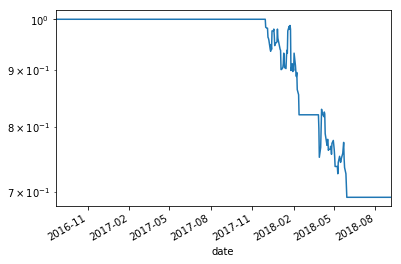

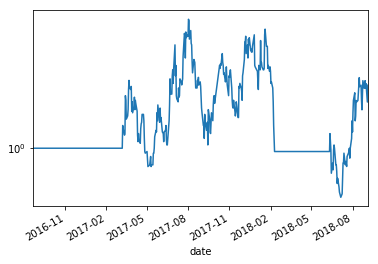

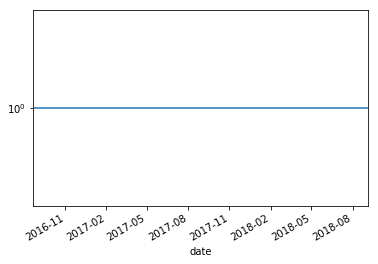

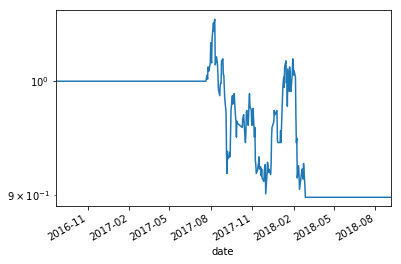

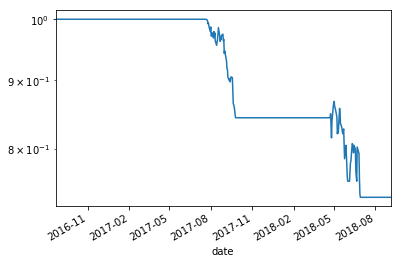

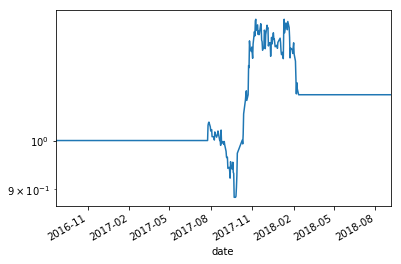

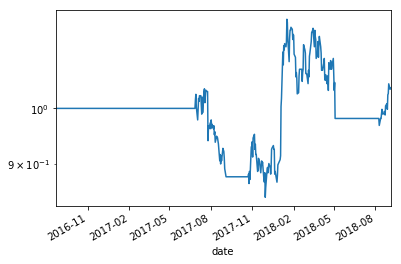

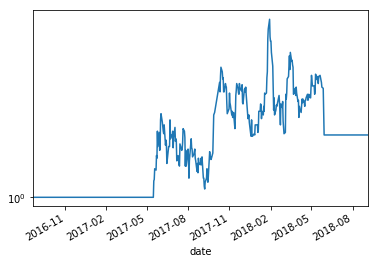

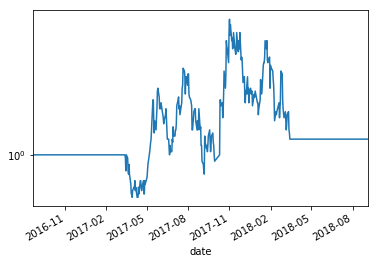

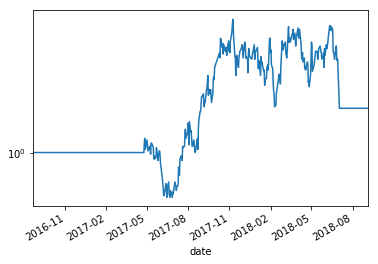

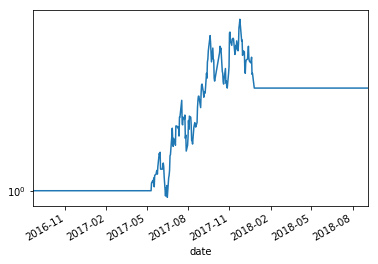

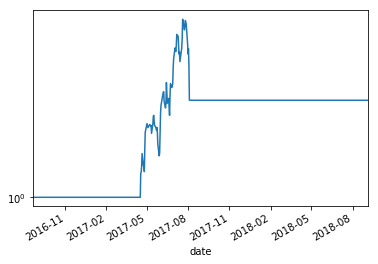

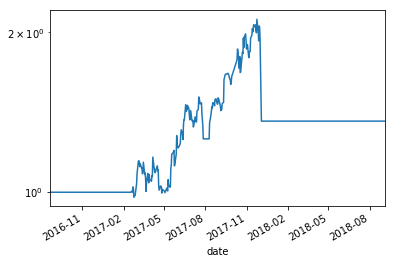

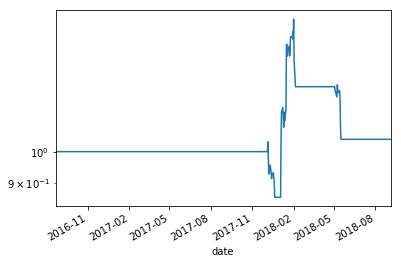

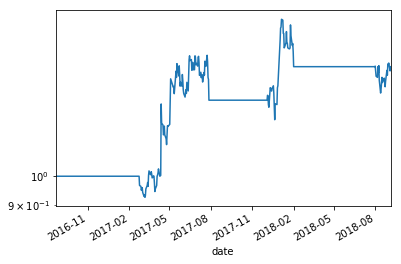

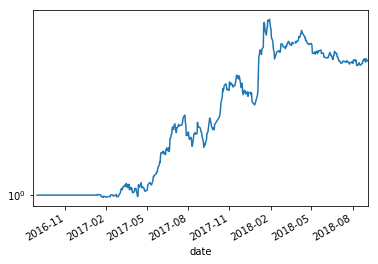

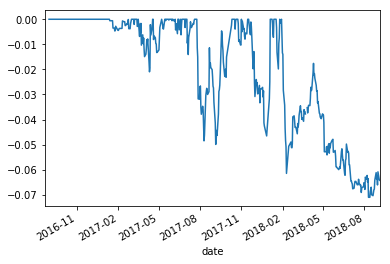

In [57]:
profit_all = pd.DataFrame()
cap_all = pd.DataFrame()
moment_all = pd.DataFrame()

for nm, code in Name2Code.items():
    close = pd.read_hdf('../data/daily_price_sample.h5', code)
    b_cond = set_cond(close)
    profit, portions, fee, is_capture = simulation(b_cond, is_show=False, is_losscut=False, is_manage=True)

    prf = (profit.pct_change(1) + 1)
    moment = cal_momentum(prf)
    is_cap_ = is_capture.shift(1).fillna(False)

    prf.name, is_cap_.name, moment.name = code, code, code
    profit_all = pd.concat([profit_all, prf], axis=1, join='outer')
    cap_all = pd.concat([cap_all, is_cap_], axis=1, join='outer')
    moment_all = pd.concat([moment_all, moment], axis=1, join='outer')

    plt.figure("profit_{}".format(nm))
    prf[~is_cap_] = 1.0
    prf_cap = prf.cumprod()
    prf_cap.plot(logy=True)
    print("[{0}]Total Profit : {1:0.4f}".format(nm,prf_cap[-1]))

b_abs = (moment_all >= 1.0)
# b_rel = (moment_all.rank(axis=1) < 5)
b_mom = b_abs #& b_rel
b_mom = b_mom.shift(1).fillna(False)

profit_all.columns = codeList
cap_all.columns = codeList
moment_all.columns = codeList

plt.figure("profit")
profit_all[~cap_all.fillna(False)] = 1.0
prf_cap = profit_all[b_mom].mean(axis=1).cumprod()
prf_cap.plot(logy=True)

plt.figure("mdd")
mdd = (prf_cap - prf_cap.cummax()) / prf_cap.cummax()
mdd.plot()
print("Total Profit : {0:0.4f} / MDD : {1:0.4f}".format(prf_cap[-1], mdd.min()))

In [48]:
b_mom.fillna(False).sum(axis=1).sum()

10